# Indicateurs des données IRVE

In [47]:
log = indicateurs()

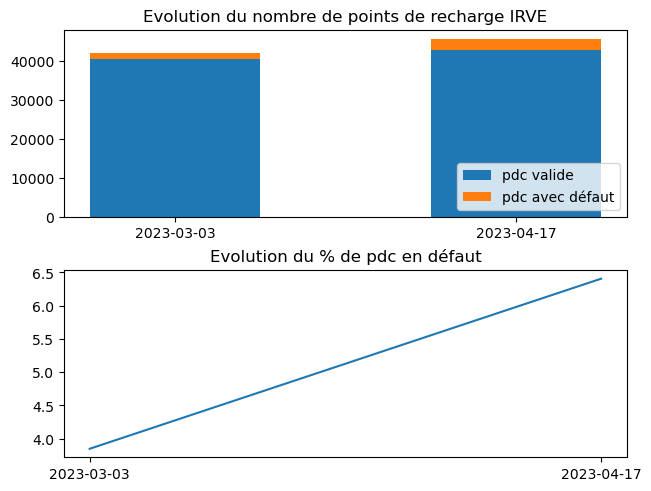

In [51]:
evolution(log)

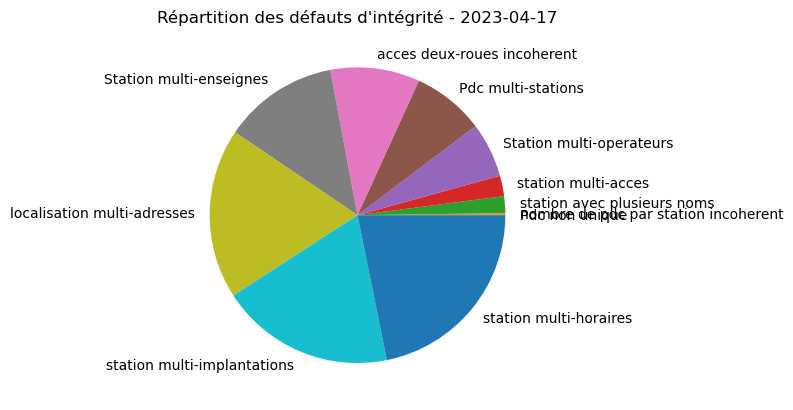

In [52]:
defaut_integrite(log)

In [50]:
defaut_carte(irve_p, irve_s).show('irve.html')

## Annexe - Fonctions utilisées

In [42]:
def indicateurs():
    log = []
    with open('logfile.txt', 'r', encoding="utf-8") as f:
        for line in f:
            log.append(json.loads(line))
    return log

In [45]:
import matplotlib.pyplot as plt

def defaut_integrite(indic):
    #val = { regles[ind-17]: indic[regles[ind-17]] for ind in range(17,29) if indic[regles[ind-17]] > 0 }
    val = dict(item for ind, item in enumerate(log[len(indic)-1].items()) if 22 < ind < 35 and item[1] > 0)
    val = dict(sorted(val.items(), key=lambda item:item[1], reverse=False))
    
    fig, ax = plt.subplots()
    ax.pie(list(val.values()), labels=list(val.keys()))
    ax.set_title("Répartition des défauts d'intégrité - " + log[len(indic)-1]['date_irve'])
    plt.show()

In [38]:
def evolution(log):
    dic = {}
    for i, indic in enumerate(log):
        if i == 0:
            dic['date'] = []
            dic['pdc defaut'] = []
            dic['pdc valide'] = []
            dic['pdc default %'] = []
        else:
            date = indic['date_irve']
            dic['date'].append(date)
            dic['pdc defaut'].append(indic['IRVE_itinerance_residuel' + date + '.csv'])
            dic['pdc valide'].append(indic['IRVE_itinerance_valide'   + date + '.csv'])
            dic['pdc default %'].append(100 * dic['pdc defaut'][-1] / (dic['pdc defaut'][-1] + dic['pdc valide'][-1]))

    width = 0.5

    fig, (ax2, ax1) = plt.subplots(2, 1, layout='constrained')
    ax1.plot(dic['date'], dic['pdc default %'])
    ax1.set_title('Evolution du % de pdc en défaut')

    bottom = [0] * (len(log) - 1)
    p = ax2.bar(dic['date'], dic['pdc valide'], width, label='pdc valide', bottom=[0] * (len(log) - 1))
    p = ax2.bar(dic['date'], dic['pdc defaut'], width, label='pdc avec défaut', bottom=dic['pdc valide'])
    ax2.set_title("Evolution du nombre de points de recharge IRVE")
    ax2.legend(loc="lower right")

    plt.show()

In [5]:
from util_carto import Cart

def defaut_carte(irve_p, irve_s):
    popup = [[], []]
    locat = [[], []]
    for ind, irve in enumerate((irve_p, irve_s)):
        for i in range(len(irve)):
            popup[ind].append( {'id_station': irve['id_station_itinerance'][i], 
                               'id_pdc': irve['id_pdc_itinerance'][i],
                               'contact_operateur': irve['contact_operateur'][i],
                               'nom_enseigne': irve['nom_enseigne'][i],
                               'nom_station': irve['nom_station'][i],
                               'adresse_station': irve['adresse_station'][i],
                               'fichier des écarts': '<a href="https://github.com/loco-philippe/Environmental-Sensing/blob/main/python/Validation/irve/Analyse/">IRVE_itinerance_residuel</a>' } )
            coord = json.loads(irve['coordonneesXY'][i])
            coord.reverse()
            locat[ind].append(coord)

    cart = Cart([50, 2.5])
    cart.add_markers(locat[0], popup=popup[0], color='red', group='écarts entités', max_width=250)
    cart.add_markers(locat[1], popup=popup[1], color='orange', group='écarts attributs', max_width=250, icon='bug')
    return cart